In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM, GRU, Bidirectional, ConvLSTM1D
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score
from keras import regularizers
import matplotlib.pyplot as plt
from keras_self_attention import SeqSelfAttention
%matplotlib inline

In [2]:
def load_train_dev_test_data():
    train, dev, test = [], [], []
    for x in open('./train_enc.tsv', encoding='utf-8'):
        x = x.rstrip('\n\r').split('\t')
        # x[0] will be the label (0 or 1), and x[1] will be the ciphertext sentence.
        x[0] = int(x[0]) 
        train.append(x)
    for x in open('./dev_enc.tsv', encoding='utf-8'):
        x = x.rstrip('\n\r').split('\t')
        # x[0] will be the label (0 or 1), and x[1] will be the ciphertext sentence.
        x[0] = int(x[0]) 
        dev.append(x)
    for x in open('./test_enc_unlabeled.tsv', encoding='utf-8'):
        x = x.rstrip('\n\r')
        test.append(x)
    return train, dev, test

In [3]:
train, dev, test = load_train_dev_test_data()

In [4]:
def create_text_label_split(data, is_test=False):
    texts = []
    labels = []
    for row in data:
        texts.append(row[1])
        if not is_test:
            labels.append(row[0])
    return texts, labels

In [5]:
def create_texts_split(data):
    texts_split = []
    for sentence in data:
        texts_split.append(sentence.split(' '))
    return texts_split

In [6]:
def create_vocabulary(data):
    vocab = set()
    for sentence in data:
        vocab = vocab.union(set(sentence))
    return vocab

In [7]:
# Split the dataset and pre-process it

#Train dataset
train_texts, train_labels = create_text_label_split(train)
train_texts_split = create_texts_split(train_texts)

#Dev dataset
dev_texts, dev_labels = create_text_label_split(dev)
dev_texts_split = create_texts_split(dev_texts)

#Test dataset
test_texts, _ = create_text_label_split(test, is_test=True) 
test_texts_split = create_texts_split(test_texts)

train_dev_texts_split = train_texts_split + dev_texts_split
train_dev_labels = train_labels + dev_labels

all_texts_split = train_texts_split + dev_texts_split + test_texts_split

In [8]:
# calculate max seq len
def get_max_seq_len(data):
    return max([len(seq) for seq in data])

In [9]:
# Setting the max_seq_len over all data
max_seq_len = get_max_seq_len(all_texts_split)

In [10]:
# Create a vocabulary

# using train
# vocab = create_vocabulary(train_texts_split) 

#using train + dev
# vocab = create_vocabulary(train_dev_texts_split)

# using all (train + dev + test)
vocab = create_vocabulary(all_texts_split)

vocab_size = len(vocab) + 1

In [11]:
# Tokenize the dataset
def get_padded_sequences(vocab, data, max_seq_len):
    tokenizer = Tokenizer(filters=[])
    tokenizer.fit_on_texts(vocab)
    seq = tokenizer.texts_to_sequences(data)
    seq_pad = pad_sequences(seq, maxlen=max_seq_len)
    return seq_pad

In [12]:
X_train = get_padded_sequences(vocab,train_texts_split, max_seq_len)
X_dev = get_padded_sequences(vocab, dev_texts_split, max_seq_len)
X_test = get_padded_sequences(vocab, test_texts_split, max_seq_len)

In [13]:
y_train = np.array(train_labels)
y_dev = np.array(dev_labels)

In [14]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 56, 32)            685600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                2640      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 689,341
Trainable params: 689,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
127/127 [==============================] - 165s 1s/step - loss: 1.1814 - accuracy: 0.5366 - val_loss: 0.9229 - val_accuracy: 0.5451
Epoch 2/100
127/127 [==============================] - 158s 1s/step - loss: 0.7426 - accuracy: 0.7089 

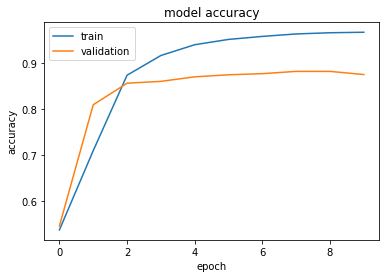

64/64 - 8s - loss: 0.4425 - accuracy: 0.8742
[0.44245973229408264, 0.874198317527771]


In [17]:
def create_model(vocab_size, max_seq_len, embedding_len, dropout):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_len, input_length=max_seq_len))
#     model.add(GRU(100, 
#                   return_sequences=True, 
#                   dropout=dropout, 
#                   recurrent_dropout=dropout,
#                   kernel_regularizer=regularizers.l2(l2=0.1), 
#                   recurrent_regularizer=regularizers.l2(l2=0.1)))
    model.add(Bidirectional(GRU(10, 
#                                  return_sequences=True,
                                 dropout=dropout, 
                                 recurrent_dropout=dropout,
                                 kernel_regularizer='l2', 
                                 recurrent_regularizer='l2')))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, 
                    activation='sigmoid', 
                    kernel_regularizer='l2'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    
    return  model

early_stoping_callback = EarlyStopping(patience=5, min_delta=0.001)
tensorboard_callback = TensorBoard()

callbacks = [
    early_stoping_callback,
    tensorboard_callback
]

model_checkpoint_callback = ModelCheckpoint(monitor='val_accuracy',filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5')

model = create_model(vocab_size, max_seq_len, 32, 0.4)

history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_dev, y_dev), verbose=1,
                   callbacks=callbacks)

plot_history(history)

scores = model.evaluate(X_dev, y_dev, verbose=2)
print(scores)

In [16]:
results = model.predict(X_test)
results = [1 if(x > 0.5) else 0 for x in results]
# write your prediction results to 'upload_predictions.txt' and upload that later
with open('upload_predictions.txt', 'w', encoding = 'utf-8') as fp:
    for x in results:
        fp.write(str(x) + '\n')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [18]:
model.save('bi_gru_recurrent_dropout.h5')